In [1]:
import torchvision.transforms as transforms   
from torch.utils.data import DataLoader       

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from tqdm import tqdm
import os
import random

from skimage import io,color
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report,hamming_loss
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

import copy
import time

import warnings
warnings.filterwarnings('ignore')

# 1. Data preparation and import

### Build Ingredients word list

In [2]:
# build vocabulary
ingredient = []
ingredient_set = []
with open(r'Recipes5k/annotations/ingredients_simplified_Recipes5k.txt', 'r') as file:

    for line in file:
        line = line.replace('\n','')
        ingredient_list = line.split(',')
        
        for word in ingredient_list:
            if word in ingredient:
                pass
            else:
                ingredient.append(word)
                
        ingredient_list = list(set(ingredient_list))
        ingredient_set.append(ingredient_list)           

In [3]:
ingredient_nums = {}
for i in ingredient:
    ingredient_nums.update({i:0})
for i in ingredient_set:
    for j in i:
        ingredient_nums[j] = ingredient_nums[j]+1

In [4]:
# Remove occurrences less than 7 times
ingredient_clean = copy.deepcopy(ingredient)
for i in ingredient:
    num = ingredient_nums[i]
    
    if num <= 7 :
        ingredient_clean.remove(i)

In [5]:
ingredient_set_clean =  copy.deepcopy(ingredient_set)
for ind,i in enumerate(ingredient_set):
    for j in i:

        if j not in ingredient_clean:
            ingredient_set_clean[ind].remove(j)

for i in ingredient_set_clean:
    if len(i)== 0:
        print(i)

In [6]:
def dataprepare(ingredient_set,image_path,label_path):
    image_path_list = []
    with open(image_path, 'r') as file:
        for line in file:
            line = line.replace('\n','')
            path = 'Recipes5k/images/'+line
            
            image_path_list.append(path)
    label_list = []
    
    with open(label_path, 'r') as file:
        for line in file:
            label = int(line)
            ingredient = ','.join(ingredient_set[label])
            label_list.append(ingredient)
    dic = {
        'image_url':image_path_list,
        'ingredient':label_list        
    }
    
    df = pd.DataFrame(dic)
    return df

In [7]:
train_df = dataprepare(ingredient_set_clean,
                image_path=r'Recipes5k/annotations/train_images.txt',
               label_path=r'Recipes5k/annotations/train_labels.txt')

test_df = dataprepare(ingredient_set_clean,
                image_path=r'Recipes5k/annotations/test_images.txt',
               label_path=r'Recipes5k/annotations/test_labels.txt')

val_df = dataprepare(ingredient_set_clean,
                image_path=r'Recipes5k/annotations/val_images.txt',
               label_path=r'Recipes5k/annotations/val_labels.txt')

train_df

,image_url,ingredient
0,Recipes5k/images/apple_pie/20_homemade_apple_p...,"apple,cinnamon,sugar,salt,oil,flour,cold water..."
1,Recipes5k/images/apple_pie/43_homestyle_apple_...,"pie,apple,cinnamon,milk,sugar,flour,lemon,butter"
2,Recipes5k/images/apple_pie/28_apple_pie_hosted...,"apple,cinnamon,sugar,salt,ice water,flour,lemo..."
3,Recipes5k/images/apple_pie/39_classic_apple_pi...,"apple,pie,cinnamon,egg,sugar,lemon,cold water,..."
4,Recipes5k/images/apple_pie/13_mug_apple_pie_ho...,"apple,pie,cinnamon,brown sugar,allspice,butter..."
...,...,...
3404,Recipes5k/images/chocolate_ice_cream/12_carame...,"milk,egg,sugar,salt,chocolate"
3405,Recipes5k/images/chocolate_ice_cream/32_chocol...,"cheese,cocoa,milk,sugar,vanilla,whipping,choco..."
3406,Recipes5k/images/chocolate_ice_cream/8_milkies...,"cocoa,corn syrup,milk,sugar,salt,chocolate,cor..."
3407,Recipes5k/images/chocolate_ice_cream/7_chocola...,"cocoa,milk,egg,sugar,vanilla,whipping,chocolate"


### One-Hot Encoding

In [8]:
def ingredient2vec(string,ingredient):
    vector = np.zeros(len(ingredient))
    lis = string.split(',')
    for i in lis:
        ind = ingredient.index(i)
        vector[ind] = 1
    return vector

def vec2ingredient(vector,ingredient):
    lis = []
    res = []
    for ind,i in enumerate(vector):
        if i == 1:
            lis.append(ind)
    for i in lis:
        name = ingredient[i]
        res.append(name)
    return res


In [9]:
class Dataset(Dataset):
    def __init__(self, data_paths, labels, transform=None):
        self.data_paths = data_paths  
        self.labels = labels  
        self.transform = transform

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        image_path = self.data_paths[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        

        return image, label

In [10]:
image_paths_train = train_df['image_url'].tolist()
labels_train = train_df['ingredient'].tolist()
labels_train = [ingredient2vec(x,ingredient_clean) for x in labels_train]

dataset_train = Dataset(image_paths_train,labels_train,transform=transforms.ToTensor())
dataloader_train = DataLoader(dataset_train, batch_size= 1, shuffle=True)

mean = 0.0
std = 0.0
for images, _ in tqdm(dataloader_train):
    batch_samples = images.size(0)  
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(dataloader_train.dataset)
std /= len(dataloader_train.dataset)

print("Mean:", mean)
print("Std:", std)

100%|█████████████████████████████████████████████████████████████████████████████| 3409/3409 [00:14<00:00, 231.57it/s]

Mean: tensor([0.6256, 0.5283, 0.4208])
Std: tensor([0.2287, 0.2468, 0.2673])


In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((299,299)),

    
])

batch_size = 25

image_paths_train = train_df['image_url'].tolist()
labels_train = train_df['ingredient'].tolist()
labels_train = [ingredient2vec(x,ingredient_clean) for x in labels_train]

dataset_train = Dataset(image_paths_train,labels_train,transform=transform)
dataloader_train = DataLoader(dataset_train, batch_size= batch_size, shuffle=True)

image_paths_test = test_df['image_url'].tolist()
labels_test = test_df['ingredient'].tolist()
labels_test = [ingredient2vec(x,ingredient_clean) for x in labels_test]

dataset_test = Dataset(image_paths_test,labels_test,transform=transform)
dataloader_test = DataLoader(dataset_test, batch_size= batch_size, shuffle=True)

image_paths_val = val_df['image_url'].tolist()
labels_val = val_df['ingredient'].tolist()
labels_val = [ingredient2vec(x,ingredient_clean) for x in labels_val]

dataset_val = Dataset(image_paths_val,labels_val,transform=transform)
dataloader_val = DataLoader(dataset_val, batch_size= 10, shuffle=True)

tensor([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

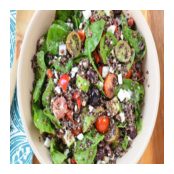

In [12]:
for batch in dataloader_train:
    X_batch,y_batch = batch
    print(y_batch[0])
    print(vec2ingredient(y_batch[0],ingredient_clean))
    image_gray = X_batch.permute(0, 2, 3,1)[0]
    plt.figure(figsize=(2, 2))
    plt.imshow(image_gray)
    plt.axis('off')
    
    break

# 2. Pretrained Model Selection：VGG16_bn, ResNet50，Iception

In [12]:
from torchvision import models
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout,BCEWithLogitsLoss,Module
from torch.optim import Adam, SGD
import torch.nn.functional as F

In [13]:
def evalVGG(pretrained_model,dataloarder,treshold = 0):
    device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
    pretrained_model.to(device)
    pretrained_model.eval()
    true_labels_vgg = []
    predicted_labels_vgg = []

    with torch.no_grad():
        for batch_X, batch_y in tqdm(dataloarder):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device) 
            outputs = pretrained_model(batch_X)

            threshold = treshold

            predicted = (outputs.cpu().numpy()>threshold).astype(int)

            true_labels_vgg.extend(batch_y.cpu().numpy().astype(int))
            predicted_labels_vgg.extend(predicted)
    
    ham = hamming_loss(true_labels_vgg, predicted_labels_vgg)
    precision = precision_score(true_labels_vgg, predicted_labels_vgg,average='micro')
    recall = recall_score(true_labels_vgg, predicted_labels_vgg,average='micro')
    f1 = f1_score(true_labels_vgg, predicted_labels_vgg,average='micro')

    print("Test hamming loss:", ham)
    print("Test precision:", precision)
    print("Test recall:", recall)
    print("Test F1-socre:", f1)
    
    return true_labels_vgg,predicted_labels_vgg

In [14]:
class CNN(Module): 
    def __init__(self):
        super(CNN, self).__init__()  
        
        # (batch_size,1,50,50)
        self.conv1 = Conv2d(3, 16, kernel_size=3) 
        self.bn1 = BatchNorm2d(16)
        self.conv2 = Conv2d(16, 32, kernel_size=3) 
        self.bn2 = BatchNorm2d(32)
        self.pool = MaxPool2d(4, 4) 
        self.fc1 = Linear(10368, 4096)  
        self.fc2 = Linear(4096, 369)  
        self.dropout = Dropout(0.5)
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, self.flat_features(x)) 
        x = F.relu(self.fc1(x)) 
        x = self.dropout(x)
        x = self.fc2(x)         
        return x
    
    def flat_features(self, x): 
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

## CNN

In [16]:
cnn = CNN()
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
cnn = cnn.to(device)

criterion = BCEWithLogitsLoss()
optimizer = Adam(cnn.parameters(), lr = 0.001) 
criterion = criterion.to(device)
best_validation_loss = float('inf')
no_improvement_count = 0
torrance = 5 

for epoch in tqdm(range(20)):
    training_loss = []
    test_loss = []
    cnn.train()
    for batch_X,batch_y in dataloader_train:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()        
        pred_y = cnn(batch_X)    
        loss = criterion(pred_y, batch_y)      
        loss.backward()
        optimizer.step() 
        training_loss.append(loss.item())


    cnn.eval()
    with torch.no_grad():
        for batch_X, batch_y in dataloader_test:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device) 
            outputs =cnn(batch_X)
            loss_eval = criterion(outputs, batch_y) 
            test_loss.append(loss_eval.item())

    test_current_loss = np.mean(test_loss)

    if test_current_loss < best_validation_loss:
        best_validation_loss = test_current_loss
        no_improvement_count = 0
        # torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improvement_count += 1

    if  no_improvement_count>= torrance:   
        print(f"Early stopping after {epoch} epochs.")
        break

del loss
del pred_y
torch.cuda.empty_cache()  

 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [06:16<02:41, 26.92s/it]

Early stopping after 14 epochs.


In [19]:
true_labels_cnn,predicted_labels_cnn = evalVGG(cnn,dataloader_test,treshold = -1.5)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 11.30it/s]


Test hamming loss: 0.03203231266029136
Test precision: 0.35457885811192763
Test recall: 0.34861747950534944
Test F1-socre: 0.351572899880894


In [20]:
cnn.cpu()
torch.save(cnn.state_dict(),'CNN.pth')

### VGG16_bn Trainning

In [46]:
# Import the pretrain model
pretrained_model = models.vgg16_bn(pretrained=True)
# Freeze model weights
for param in pretrained_model.parameters():
    param.requires_grad = False

# Add on classifier
pretrained_model.classifier[6] = Sequential(Linear(4096, 369))
for param in pretrained_model.classifier[6].parameters():
    param.requires_grad = True
    
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")
pretrained_model = pretrained_model.to(device)


criterion = BCEWithLogitsLoss()
optimizer = Adam(pretrained_model.parameters(), lr=0.001)
criterion = criterion.to(device)

Computation device: cuda:0


In [47]:
num_epochs = 20

# early stopping
best_validation_loss = float('inf')
no_improvement_count = 0
torrance = 5 

for epoch in tqdm(range(num_epochs)):
    pretrained_model.train()
    training_loss = []
    test_loss = []
    
    for batch_X, batch_y in dataloader_train:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()  
        pred_y = pretrained_model(batch_X)
        loss = criterion(pred_y, batch_y)
        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    training_loss = np.mean(training_loss)

    pretrained_model.eval()
    with torch.no_grad():
        for batch_X, batch_y in dataloader_test:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device) 
            outputs = pretrained_model(batch_X)
            loss_eval = criterion(outputs, batch_y) 
            test_loss.append(loss_eval.item())
   
    test_current_loss = np.mean(test_loss)

    if test_current_loss < best_validation_loss:
        best_validation_loss = test_current_loss
        no_improvement_count = 0
        # torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improvement_count += 1

    if  no_improvement_count>= torrance:   
        print(f"Early stopping after {epoch} epochs.")
        break

del loss
del pred_y
torch.cuda.empty_cache() 

 40%|█████████████████████████████████▏                                                 | 8/20 [06:11<09:17, 46.42s/it]

Early stopping after 8 epochs.


In [48]:
true_labels_vgg,predicted_labels_vgg = evalVGG(pretrained_model,dataloader_test,treshold = -1)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.22it/s]

Test hamming loss: 0.02880312328027495
Test precision: 0.4235629841011007
Test recall: 0.433097123801584
Test F1-socre: 0.4282769991755977


In [49]:
pretrained_model.cpu()
torch.save(pretrained_model.state_dict(),'VGG16.pth')

## ResNet 50

In [50]:
# Import the pretrain model
pretrained_model_2 = models.resnet50(pretrained=True)
pretrained_model_2.fc = Linear(pretrained_model_2.fc.in_features, 369)

pretrained_model_2 = pretrained_model_2.to(device)
criterion = BCEWithLogitsLoss()
optimizer = Adam(pretrained_model_2.parameters(), lr=0.001)
criterion = criterion.to(device)



In [ ]:
num_epochs = 40

# early stopping
best_validation_loss = float('inf')
no_improvement_count = 0
torrance = 5 

for epoch in tqdm(range(num_epochs)):
    pretrained_model_2.train()
    training_loss = []
    test_loss = []
    for batch_X, batch_y in dataloader_train:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()  
        pred_y = pretrained_model_2(batch_X)
        loss = criterion(pred_y, batch_y)
        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    training_loss = np.average(training_loss)
    
    pretrained_model_2.eval()
    with torch.no_grad():
        for batch_X, batch_y in dataloader_test:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device) 
            outputs = pretrained_model_2(batch_X)
            loss_eval = criterion(outputs, batch_y) 
            test_loss.append(loss_eval.item())
   
    test_current_loss = np.mean(test_loss)
    
    if test_current_loss < best_validation_loss:
        best_validation_loss = test_current_loss
        no_improvement_count = 0
        # torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improvement_count += 1
    
    if  no_improvement_count>= torrance:   
        print(f"Early stopping after {epoch} epochs.")
        break

del loss
del pred_y
torch.cuda.empty_cache() 


 18%|██████████████                                                                  | 7/40 [23:26<1:46:16, 193.23s/it]

In [33]:
pretrained_model_2.cpu()
torch.save(pretrained_model_2.state_dict(),'RestNet.pth')

In [39]:
true_labels_rn,predicted_labels_rn = evalVGG(pretrained_model_2,dataloader_test,treshold = -1.25)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  6.78it/s]

Test precision: 0.36442544371032515
Test recall: 0.3908573016534667
Test F1-socre: 0.3771788683293108


In [40]:
torch.cuda.empty_cache()

## Inception V3

In [22]:
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
inception_v3 = models.inception_v3(pretrained=True)
inception_v3.fc = torch.nn.Linear(inception_v3.fc.in_features, 369)
criterion =  BCEWithLogitsLoss()
optimizer = Adam(inception_v3.parameters(), lr=0.001)

inception_v3.to(device)
criterion = criterion.to(device)

In [27]:
num_epochs = 5

# early stopping
best_validation_loss = float('inf')
no_improvement_count = 0
torrance = 5 

for epoch in tqdm(range(num_epochs)):
    inception_v3.train()
    training_loss = []
    test_loss = []
    for batch_X, batch_y in dataloader_train:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()  
        pred_y = inception_v3(batch_X)
        loss = criterion(pred_y.logits, batch_y)
        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    training_loss = np.average(training_loss)
    '''
    inception_v3.eval()
    with torch.no_grad():
        for batch_X, batch_y in dataloader_test:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device) 
            outputs = inception_v3(batch_X)
            loss_eval = criterion(outputs, batch_y) 
            test_loss.append(loss_eval.item())
   
    test_current_loss = np.mean(test_loss)

    if test_current_loss < best_validation_loss:
        best_validation_loss = test_current_loss
        no_improvement_count = 0
        # torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improvement_count += 1

    if  no_improvement_count>= torrance:   
        print(f"Early stopping after {epoch} epochs.")
        break
    '''

del loss
del pred_y
torch.cuda.empty_cache() 

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [21:22<00:00, 256.42s/it]


In [28]:
true_labels_in,predicted_labels_in = evalVGG(inception_v3,dataloader_test,treshold = -1)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:13<00:00,  2.39it/s]


Test hamming loss: 0.03099052701893558
Test precision: 0.36739622641509434
Test recall: 0.3381964707517021
Test F1-socre: 0.3521921574301837


In [29]:
inception_v3.cpu()
torch.save(inception_v3.state_dict(),'InspectionV3.pth')

# 3. Model effect display

In [13]:
from torchvision import models
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout,BCEWithLogitsLoss
from torch.optim import Adam, SGD


In [14]:
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")

Computation device: cuda:0


In [15]:
def resultvisualization_VGG(model_path,dataloader_val,picture=10,device='cpu'):
    custom_model = models.vgg16_bn()
    custom_model.classifier[6] = Sequential(Linear(4096, 369))
    custom_model.load_state_dict(torch.load(model_path))
      
    custom_model.to(device)
    
    true_labels_vgg = []
    predicted_labels_vgg = []
    image = []
    
    with torch.no_grad():
        for batch_X, batch_y in dataloader_val:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device) 
            outputs = custom_model(batch_X)
            
            threshold = -1

            predicted = (outputs.cpu().numpy()>threshold).astype(int)

            true_labels_vgg.extend(batch_y.cpu().numpy().astype(int))
            predicted_labels_vgg.extend(predicted)
            image.extend(batch_X.cpu().numpy())
    
    
    for i in range(picture):
        rl = vec2ingredient(true_labels_vgg[i],ingredient_clean)
        pd = vec2ingredient(predicted_labels_vgg[i],ingredient_clean)
        
        ur = [i for i in rl if i not in pd]
        cr = [i for i in pd if i in rl]
        er = [i for i in pd if i not in rl]
        
        print('Real Ingredients:',','.join(rl))
        print('Predicted Ingredients:',','.join(pd))

        print(f"\x1b[32mCorrect instance:{','.join(cr)}\x1b[0m")
        print(f"\x1b[31mUnrecognized:{','.join(ur)}\x1b[0m")
        print(f"\x1b[31mMisrecognized:{','.join(er)}\x1b[0m")
        image_gray = image[i].transpose((1,2,0))

        
        rate = len(cr)/len(rl)*100
        
        plt.figure(figsize=(2, 2))
        plt.imshow(image_gray)
        # plt.title(f'Recognition rate:{rate:.2f}%')
        plt.axis('off')
        plt.show()     
        
        print('-'*80)
    

    del custom_model,image
    
    return true_labels_vgg,predicted_labels_vgg
        

Real Ingredients: onion,flour,salt,oil,butter,pepper,cheese,potato,beef,gravy
Predicted Ingredients: salt,egg,garlic,oil,butter,cheese,sugar,waffle
Correct instance:salt,oil,butter,cheese
Unrecognized:onion,flour,pepper,potato,beef,gravy
Misrecognized:egg,garlic,sugar,waffle


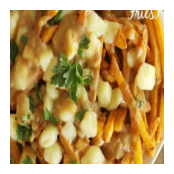

--------------------------------------------------------------------------------
Real Ingredients: onion,bread,cayenne pepper,pepper,cheese,gin,pumpkin
Predicted Ingredients: flour,salt,egg,milk,bread,pepper,cheese,cheddar
Correct instance:bread,pepper,cheese
Unrecognized:onion,cayenne pepper,gin,pumpkin
Misrecognized:flour,salt,egg,milk,cheddar


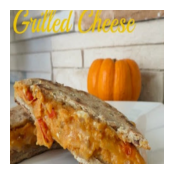

--------------------------------------------------------------------------------
Real Ingredients: onion,salt,paprika,garlic,oil,black pepper,pepper,bay leaf,quinoa,peas,shrimp,seafood,tomato,broth,saffron
Predicted Ingredients: onion,salt,paprika,garlic,oil,black pepper,pepper,parsley,gin,quinoa,shrimp
Correct instance:onion,salt,paprika,garlic,oil,black pepper,pepper,quinoa,shrimp
Unrecognized:bay leaf,peas,seafood,tomato,broth,saffron
Misrecognized:parsley,gin


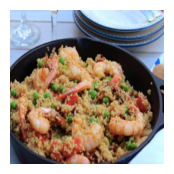

--------------------------------------------------------------------------------
Real Ingredients: pepper,spray,cheese,gyoza wrappers,pasta
Predicted Ingredients: flour,salt,garlic,oil,butter,pepper,potato,gin,gyoza wrappers,cabbage
Correct instance:pepper,gyoza wrappers
Unrecognized:spray,cheese,pasta
Misrecognized:flour,salt,garlic,oil,butter,potato,gin,cabbage


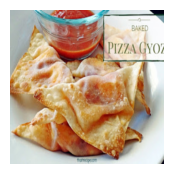

--------------------------------------------------------------------------------
Real Ingredients: onion,salt,oil,butter,pepper,barbecue,pork,cloves,honey,dijon mustard,soy,broth,buns
Predicted Ingredients: onion,flour,salt,egg,milk,oil,nut,butter,barbecue,pork,brown sugar,sugar,cloves,vanilla,buns
Correct instance:onion,salt,oil,butter,barbecue,pork,cloves,buns
Unrecognized:pepper,honey,dijon mustard,soy,broth
Misrecognized:flour,egg,milk,nut,brown sugar,sugar,vanilla


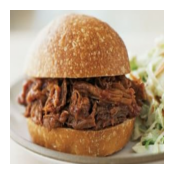

--------------------------------------------------------------------------------
Real Ingredients: salt,bread,paprika,oil,black pepper,lemon,potato,fat,peas,tomato
Predicted Ingredients: onion,salt,bread,paprika,garlic,oil,black pepper,pepper,cheese,lemon,mayonnaise,potato,tomato
Correct instance:salt,bread,paprika,oil,black pepper,lemon,potato,tomato
Unrecognized:fat,peas
Misrecognized:onion,garlic,pepper,cheese,mayonnaise


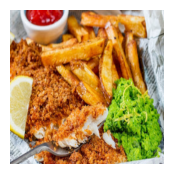

--------------------------------------------------------------------------------
Real Ingredients: flour,baking,salt,egg,butter,water,sugar,vanilla,chocolate
Predicted Ingredients: flour,baking,salt,egg,butter,cheese,water,sugar,vanilla,chocolate
Correct instance:flour,baking,salt,egg,butter,water,sugar,vanilla,chocolate
Unrecognized:
Misrecognized:cheese


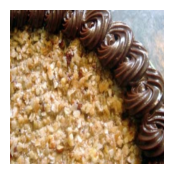

--------------------------------------------------------------------------------
Real Ingredients: onion,water,miso,tofu,dashi
Predicted Ingredients: salt,egg,butter,water,sugar,gin,miso,tofu,dashi,broth,beans,tahini
Correct instance:water,miso,tofu,dashi
Unrecognized:onion
Misrecognized:salt,egg,butter,sugar,gin,broth,beans,tahini


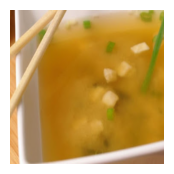

--------------------------------------------------------------------------------
Real Ingredients: onion,paprika,oil,pepper,cloves,chicken,peas,shrimp,broth,sage,saffron
Predicted Ingredients: onion,salt,paprika,garlic,oil,pepper,cheese,chicken,shrimp
Correct instance:onion,paprika,oil,pepper,chicken,shrimp
Unrecognized:cloves,peas,broth,sage,saffron
Misrecognized:salt,garlic,cheese


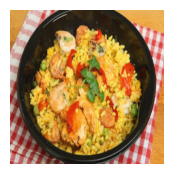

--------------------------------------------------------------------------------
Real Ingredients: soy,sake,scallions,rice,mirin,seeds,nori,sashimi
Predicted Ingredients: onion,salt,pepper,cloves,gin,miso,sriracha,anise,noodles,sashimi
Correct instance:sashimi
Unrecognized:soy,sake,scallions,rice,mirin,seeds,nori
Misrecognized:onion,salt,pepper,cloves,gin,miso,sriracha,anise,noodles


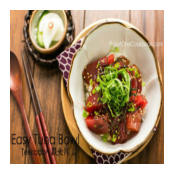

--------------------------------------------------------------------------------


In [16]:
true_labels_vgg,predicted_labels_vgg = resultvisualization_VGG('VGG16.pth',dataloader_val,picture=10,device=device)

### Rank by number of erro

In [27]:
ingredient_nums_val = copy.deepcopy(ingredient_nums)

for key,val in ingredient_nums.items():
    ingredient_nums_val[key] = 0

for i in true_labels_vgg:
    ing_list = vec2ingredient(i,ingredient_clean)
    for j in ing_list:
        ingredient_nums_val[j] += 1
    

In [26]:
ingredient_TN = {}
ingredient_FP = {}

for i in ingredient_clean:
    ingredient_TN.update({i:0})

for i in ingredient_clean:
    ingredient_FP.update({i:0})    

for i in range(len(true_labels_vgg)):
    true = true_labels_vgg[i]
    negative = predicted_labels_vgg[i]
    
    for j in range(len(true)):
        # true label
        if true[j] == 1 and negative[j]==0:
            name = ingredient_clean[j]
            ingredient_TN[name] += 1
            
    for j in range(len(true)):
        # true label
        if true[j] == 0 and negative[j]==1:
            name = ingredient_clean[j]
            ingredient_FP[name] += 1
            
    
    


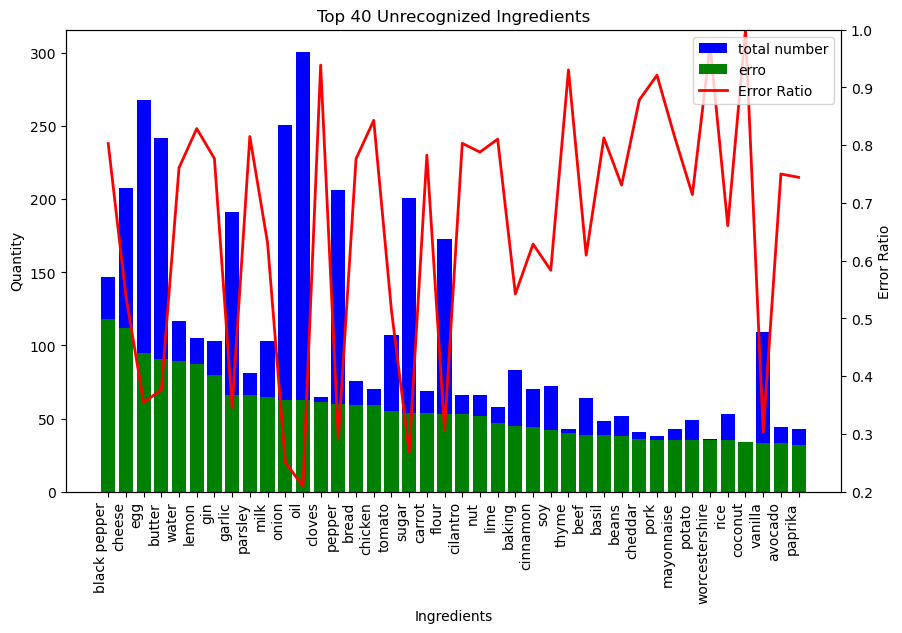

In [48]:
sorted_TN = sorted(ingredient_TN.items(), key=lambda x: x[1], reverse=True) 

TN_keys = [item[0] for item in sorted_TN][:40]
TN_values = [item[1] for item in sorted_TN][:40]
TN_total = [ingredient_nums_val[i] for i in TN_keys]
TN_ratio = [TN_values[i]/TN_total[i] for i in range(len(TN_keys))]

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(TN_keys, TN_total,color='blue',label='total number')
ax1.bar(TN_keys, TN_values,color='green',label='erro')
ax1.set_xlabel('Ingredients')
ax1.set_ylabel('Quantity')
ax1.set_xticklabels(TN_keys, rotation=90, ha='right')

# draw plot
ax2 = ax1.twinx()
ax2.plot(TN_keys, TN_ratio, color='red', linestyle='-', linewidth=2, label='Error Ratio')
ax2.set_ylabel('Error Ratio')
ax2.set_ylim(0.2,1)
ax2.tick_params(axis='y')

# labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')


plt.title('Top 40 Unrecognized Ingredients')
plt.show()


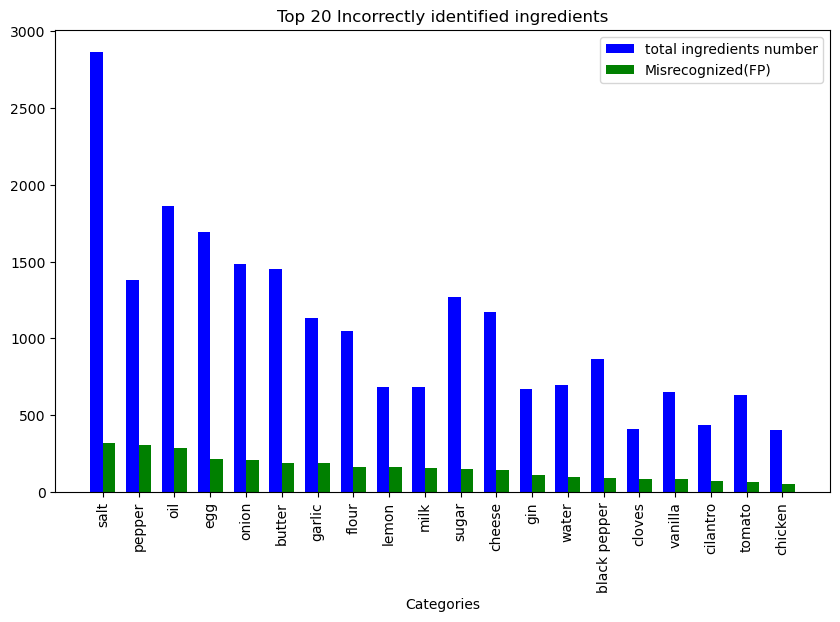

In [35]:
sorted_FP = sorted(ingredient_FP.items(), key=lambda x: x[1], reverse=True)

plt.subplots(figsize=(10, 6))
FP_keys = [item[0] for item in sorted_FP][:20]
FP_values = [item[1] for item in sorted_FP][:20]
FP_total = [ingredient_nums[i] for i in FP_keys]

x = np.arange(len(FP_values))

width = 0.35

plt.bar(x - width/2, FP_total, width, label='total ingredients number', color='blue')
plt.bar(x + width/2, FP_values, width, label='Misrecognized(FP)', color='green')

plt.xlabel('Categories')
plt.legend()
plt.xticks(x, FP_keys, rotation=90)

plt.title('Top 20 Incorrectly identified ingredients')
plt.show()


In [58]:
def visualCNN(model_path,image_path,transform):
    
    device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
    custom_model = models.vgg16_bn()
    custom_model.classifier[6] = Sequential(Linear(4096, 369))
    custom_model.load_state_dict(torch.load(model_path))
      
    model = custom_model.to(device)
    
    
    input_image = Image.open(image_path)
    input_tensor = transform(input_image)
    input_batch = input_tensor.unsqueeze(0)
    
    plt.imshow(input_image)
    plt.title('The input original image')
    plt.axis('off')
    plt.show()
    
    plt.imshow(input_tensor.permute(1,2,0), cmap='gray')
    plt.title('Preprocessed image')
    plt.axis('off')
    plt.show()
    
    
    model = model.to(device)
    input_batch = input_batch.to(device)
    
    model.eval()

    target_layer = model.features[3]  
    activation = {}

    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    target_layer.register_forward_hook(get_activation('conv2_output'))

    with torch.no_grad():
        model(input_batch)

    feature_map = activation['conv2_output'][0].cpu()
    plt.figure(figsize=(8, 8))
    
    for i in range(feature_map.size(0)):
        plt.subplot(8, 8, i + 1)
        plt.imshow(feature_map[i]) 
        plt.axis('off')
    plt.suptitle('Preprocessed image')
    plt.show()
    
    
    
    

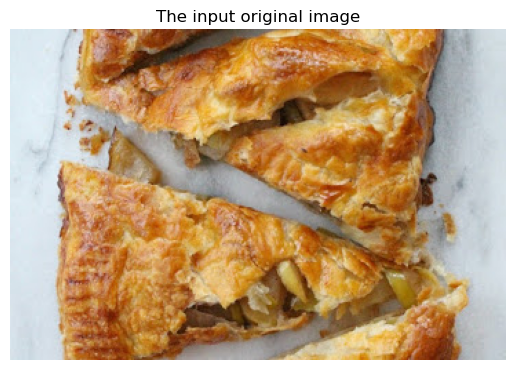

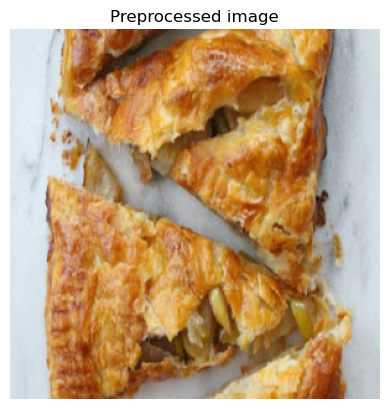

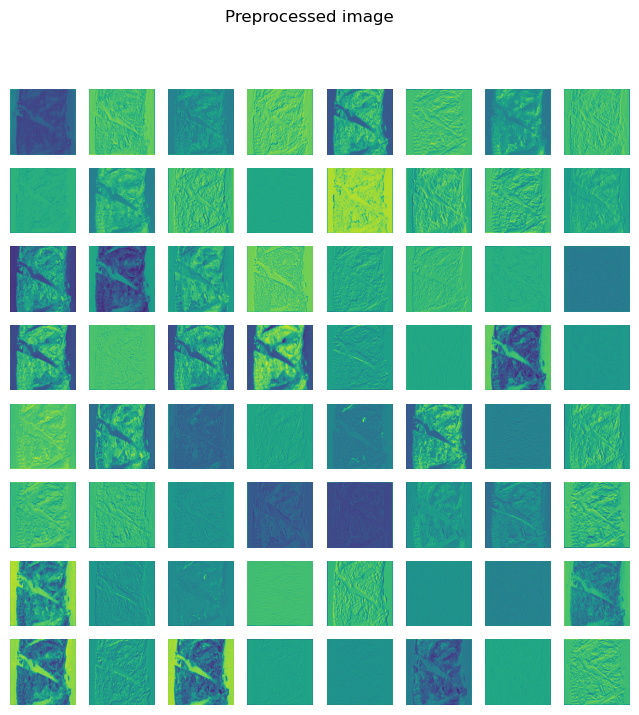

In [59]:
visualCNN('VGG16.pth',test_df.iloc[0,0],transform)

In [45]:
custom_model = models.vgg16_bn()
custom_model.classifier[6] = Sequential(Linear(4096, 369))
custom_model.load_state_dict(torch.load('VGG16.pth'))

<All keys matched successfully>

In [53]:
custom_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

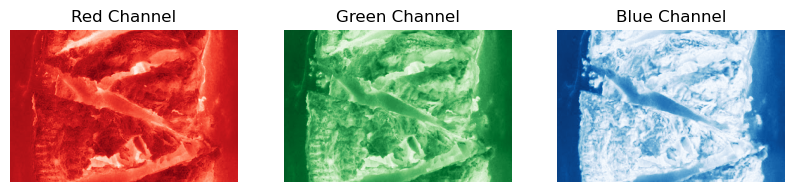

In [60]:
from PIL import Image
import matplotlib.pyplot as plt


image_path = test_df.iloc[0,0] 
image = Image.open(image_path)

red_channel, green_channel, blue_channel = image.split()

plt.figure(figsize=(10, 4))

plt.subplot(131)
plt.imshow(red_channel, cmap='Reds')
plt.title('Red Channel')
plt.axis('off')

plt.subplot(132)
plt.imshow(green_channel, cmap='Greens')
plt.title('Green Channel')
plt.axis('off')

plt.subplot(133)
plt.imshow(blue_channel, cmap='Blues')
plt.title('Blue Channel')
plt.axis('off')

plt.show()